In [1]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
import pandas as pd
import pandas as PD
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

Using TensorFlow backend.


# Loading our dataset

In [2]:
data = pd.read_csv('BTC-USD.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,1.029120e+10
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,1.684660e+10
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,1.687190e+10
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,2.178320e+10
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,2.384090e+10


In [3]:
data.dropna(inplace=True)

In [4]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,1.029120e+10
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,1.684660e+10
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,1.687190e+10
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,2.178320e+10
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,2.384090e+10
...,...,...,...,...,...,...,...
1399,2021-10-31,61850.488281,62406.171875,60074.328125,61318.957031,61318.957031,3.224120e+10
1400,2021-11-01,61320.449219,62419.003906,59695.183594,61004.406250,61004.406250,3.615057e+10
1401,2021-11-02,60963.253906,64242.792969,60673.054688,63226.402344,63226.402344,3.774667e+10
1402,2021-11-03,63254.335938,63516.937500,61184.238281,62970.046875,62970.046875,3.612473e+10


# Building a baseline model that will be compared to our HMM

In [5]:
data.isnull ().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [6]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1399,2021-10-31,61850.488281,62406.171875,60074.328125,61318.957031,61318.957031,3.224120e+10
1400,2021-11-01,61320.449219,62419.003906,59695.183594,61004.406250,61004.406250,3.615057e+10
1401,2021-11-02,60963.253906,64242.792969,60673.054688,63226.402344,63226.402344,3.774667e+10
1402,2021-11-03,63254.335938,63516.937500,61184.238281,62970.046875,62970.046875,3.612473e+10
1403,2021-11-04,62898.691406,63088.773438,61446.257813,61636.625000,61636.625000,3.519332e+10


In [7]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# Setting the Target Variable and Selecting the Features

In [8]:
#Set Target Variable
output_var = data[["Close"]]
#Selecting the Features
features = ["Open", "High","Low"]

In [9]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(data[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=data.index)
feature_transform.head()

,Open,High,Low
0,0.173277,0.170243,0.164904
1,0.165515,0.191175,0.165051
2,0.187075,0.193189,0.192872
3,0.191735,0.195811,0.187537
4,0.195025,0.226688,0.198802


# Creating a Training Set and a Test Set for Stock Market Prediction

In [10]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [11]:
#Data preprocessing for LSTM

In [12]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)

X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [13]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


# Building a simple LSTM Model for Bitcoin Prediction

In [14]:
#Building a simple LSTM Model
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))
lstm.add(LSTM(3, return_sequences=True))

lstm.add(Dense(24))
lstm.add(Dense(18))
lstm.add(Dense(22))
lstm.add(Dense(1))

lstm.compile(loss='mse', optimizer='rmsprop')


In [15]:
history=lstm.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1, shuffle=False)

Epoch 1/20
160/160 [==============================] - 6s 5ms/step - loss: 387750880.0000
Epoch 2/20
160/160 [==============================] - 1s 5ms/step - loss: 369940640.0000
Epoch 3/20
160/160 [==============================] - 1s 5ms/step - loss: 317615424.0000
Epoch 4/20
160/160 [==============================] - 1s 5ms/step - loss: 238275536.0000
Epoch 5/20
160/160 [==============================] - 1s 5ms/step - loss: 197130560.0000
Epoch 6/20
160/160 [==============================] - 1s 5ms/step - loss: 193550864.0000
Epoch 7/20
160/160 [==============================] - 1s 5ms/step - loss: 186140624.0000
Epoch 8/20
160/160 [==============================] - 1s 5ms/step - loss: 169417456.0000
Epoch 9/20
160/160 [==============================] - 1s 5ms/step - loss: 146490896.0000
Epoch 10/20
160/160 [==============================] - 1s 5ms/step - loss: 121316440.0000
Epoch 11/20
160/160 [==============================] - 1s 5ms/step - loss: 95560088.0000
Epoch 12/20
160/160 

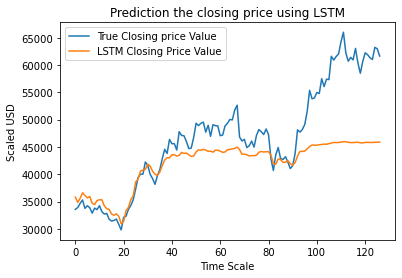

In [16]:
y_pred= lstm.predict(X_test)
y_pred = y_pred.flatten()
plt.plot(y_test, label='True Closing price Value')
plt.plot(y_pred, label='LSTM Closing Price Value')
plt.title('Prediction the closing price using LSTM')
plt.xlabel("Time Scale")
plt.ylabel("Scaled USD")
plt.legend()
plt.show()

In [17]:
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
error = calc_mape(y_pred, y_test)
print("The MEan Absolute performance Error of the LSTM Model {}".format(error))

The MEan Absolute performance Error of the LSTM Model 0.0963429724658415


# Building HMM 

# Extracting features to be used in the HMM 

In [18]:
dataset = data[['Close','Open','High','Low']]
dataset = dataset.to_numpy()

In [19]:

PLOT_SHOW=True
PLOT_TYPE = False

#Observations for testing kept aside

NUM_TEST = 100

#latency 

K = 50
NUM_ITERS=10000

labels = ['Close','Open','High','Low']
likelihood_vect = np.empty([0,1])

bic_vect = np.empty([0,1])

# Possible number of states in Markov Model
STATE_SPACE = range(1,25)

#Evaluation metric 
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [20]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

predicted_stock_data = np.empty([0,dataset.shape[1]])
likelihood_vect = np.empty([0,1])
bic_vect = np.empty([0,1])
for states in STATE_SPACE:

#Computing the number of parameters that will be fed in the GaussianHMM Model by using the formula '𝑁^2+2N-1'
    
    num_params = states**2 + 2*states-1

    model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)


    model.fit(dataset[NUM_TEST:,:])

    likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
    
#  Computing the BIC as the criteria for model selection

    bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))

# Formula for computing the optimal number of states

opt_states = np.argmin(bic_vect) + 2

print('The Optimum number of states to be considered are {}'.format(opt_states))

C:\Users\Aime Munezero\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


The Optimum number of states to be considered are 9


# Graphs showing how HMM has been used to estimate the first 100 values of the data through forecasting the close, Low, High and Open prices.

MAPE for close, open, high and Low bitcoin prices are as follows : [0.06897584 0.06024187 0.05179295 0.06398351] 


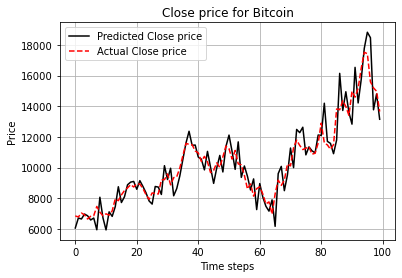

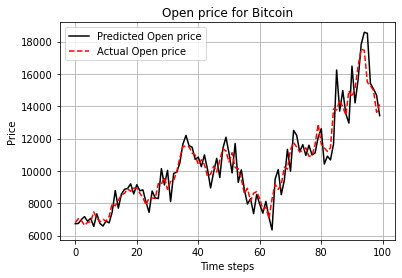

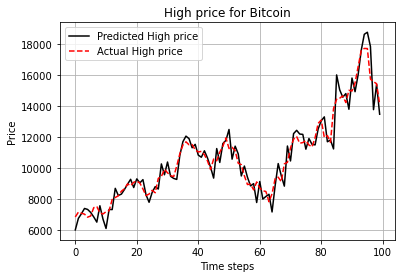

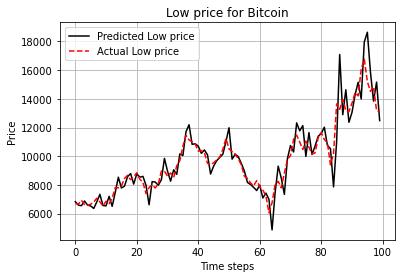

In [21]:
mape_computed=[]
for idx in reversed(range(NUM_TEST)):

    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]
    num_examples = train_dataset.shape[0]

    #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')


    if idx == NUM_TEST - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
    else:

    # Retuning the model by using the HMM paramters from the previous iterations as the prior

        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

#  transmat_ (array, shape (n_components, n_components)) – Matrix of transition probabilities between states.

    transmat_retune_prior = model.transmat_

#  startprob_ (array, shape (n_components, )) – Initial state occupation distribution.

    startprob_retune_prior = model.startprob_

    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)

    iters = 1
    past_likelihood = []

    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))

    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))

mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100),:]))
mape_computed.append(mape)
print('MAPE for close, open, high and Low bitcoin prices are as follows : {} '.format(mape))


if PLOT_TYPE:
    hdl_p = plt.plot(range(100), predicted_stock_data);
    plt.title('Predicted bitcoin prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(100),np.flipud(dataset[range(100),:]))
    plt.title('Actual bitcoin prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(100), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price');
        plt.plot(range(100),np.flipud(dataset[range(100),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.title(labels[i]+' price'+ ' for '+"Bitcoin")
        plt.grid(True)
        plt.legend(loc = 'upper left')        
if PLOT_SHOW:
    plt.show(block=False)

In [22]:
mape_computed

[array([0.06897584, 0.06024187, 0.05179295, 0.06398351])]